In [1]:
!pip install pandas requests vaderSentiment beautifulsoup4 matplotlib

In [26]:
import pandas as pd
import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from docx import Document
from docx.shared import Inches
from io import BytesIO
import matplotlib.pyplot as plt


analyzer = SentimentIntensityAnalyzer()


In [8]:
def fetch_crypto_news_newsdata(api_key, keyword="crypto", country="us", limit=10):
    url = f"https://newsdata.io/api/1/news?apikey={api_key}&q={keyword}&language=en&country={country}&category=business"

    response = requests.get(url)
    data = response.json()

    headlines = []
    if data.get("results"):
        for article in data["results"][:limit]:
            if article["title"]:
                headlines.append(article["title"])
    
    return headlines

# 🔑 Paste your actual API key here:
NEWS_API_KEY = "pub_31ebc06d739d4daa892fa43d3f5b90a4"

# Fetch news
headlines = fetch_crypto_news_newsdata(NEWS_API_KEY)
pd.DataFrame(headlines, columns=["Headline"])


,Headline
0,PERSONAL FINANCE: A look at Bitcoin and the ri...
1,PERSONAL FINANCE: A look at Bitcoin and the ri...
2,PERSONAL FINANCE: A look at Bitcoin and the ri...
3,Warren Buffett’s Berkshire Hathaway Now Earns ...
4,The Best 3 AI Crypto Buys Before The Next Bull...
5,Arctic Pablo Coin Presale Nears Completion Aft...
6,The GENIUS Act Paves the Way for U.S. Crypto I...
7,A Look at Applied Digital's Upcoming Earnings ...
8,UCLA to pay $6 million to settle complaints of...
9,Ruvi AI’s (RUVI) Presale Rockets to 70% as Ins...


In [9]:
def analyze_sentiment(headlines):
    records = []

    for headline in headlines:
        score = analyzer.polarity_scores(headline)
        sentiment = "Positive" if score["compound"] > 0.2 else "Negative" if score["compound"] < -0.2 else "Neutral"

        records.append({
            "headline": headline,
            "compound_score": score["compound"],
            "sentiment": sentiment
        })

    return pd.DataFrame(records)

sentiment_df = analyze_sentiment(headlines)
sentiment_df


,headline,compound_score,sentiment
0,PERSONAL FINANCE: A look at Bitcoin and the ri...,0.0000,Neutral
1,PERSONAL FINANCE: A look at Bitcoin and the ri...,0.0000,Neutral
2,PERSONAL FINANCE: A look at Bitcoin and the ri...,0.0000,Neutral
3,Warren Buffett’s Berkshire Hathaway Now Earns ...,0.0000,Neutral
4,The Best 3 AI Crypto Buys Before The Next Bull...,0.6369,Positive
5,Arctic Pablo Coin Presale Nears Completion Aft...,0.0000,Neutral
6,The GENIUS Act Paves the Way for U.S. Crypto I...,0.3818,Positive
7,A Look at Applied Digital's Upcoming Earnings ...,0.0000,Neutral
8,UCLA to pay $6 million to settle complaints of...,-0.4767,Negative
9,Ruvi AI’s (RUVI) Presale Rockets to 70% as Ins...,0.7430,Positive


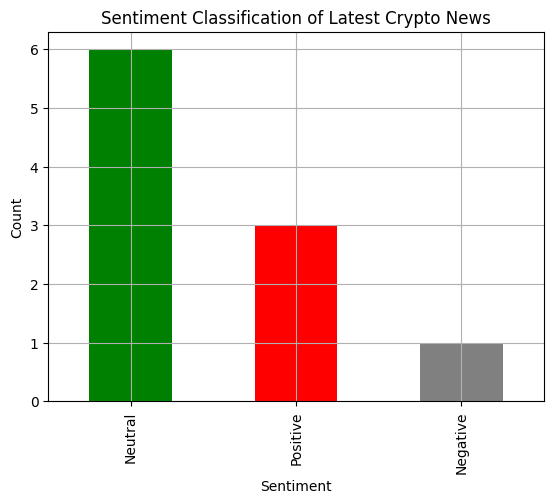

In [10]:
sentiment_df["sentiment"].value_counts().plot(kind="bar", color=["green", "red", "gray"])
plt.title("Sentiment Classification of Latest Crypto News")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [12]:
from datetime import datetime

filename = f"sentiment_news_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
sentiment_df.to_csv(filename, index=False)
print(f"Sentiment saved as {filename}")


Sentiment saved as sentiment_news_20250730_1225.csv


In [14]:
portfolio = pd.read_csv("sample_portfolio.csv")
portfolio


,asset,quantity,avg_buy_price
0,bitcoin,0.05,35000.00
1,ethereum,0.80,2000.00
2,solana,10.00,40.00
3,cardano,1000.00,0.25
4,polygon,500.00,0.80
5,dogecoin,2000.00,0.07


In [16]:
def fetch_prices(assets):
    url = "https://api.coingecko.com/api/v3/simple/price"
    ids = ",".join(assets)
    params = {
        "ids": ids,
        "vs_currencies": "usd"
    }
    response = requests.get(url, params=params)
    return response.json()

# Convert asset names to CoinGecko format
portfolio["coingecko_id"] = portfolio["asset"].str.lower()
prices = fetch_prices(portfolio["coingecko_id"].tolist())


In [17]:
def calculate_values(row):
    live_price = prices.get(row["coingecko_id"], {}).get("usd", 0)
    current_value = live_price * row["quantity"]
    invested = row["avg_buy_price"] * row["quantity"]
    gain = current_value - invested
    return pd.Series([live_price, current_value, invested, gain])

portfolio[["live_price", "current_value", "invested", "gain"]] = portfolio.apply(calculate_values, axis=1)
portfolio["gain_percent"] = (portfolio["gain"] / portfolio["invested"]) * 100
portfolio


,asset,quantity,avg_buy_price,coingecko_id,live_price,current_value,invested,gain,gain_percent
0,bitcoin,0.05,35000.00,bitcoin,118283.000000,5914.150,1750.0,4164.150,237.951429
1,ethereum,0.80,2000.00,ethereum,3827.400000,3061.920,1600.0,1461.920,91.370000
2,solana,10.00,40.00,solana,181.650000,1816.500,400.0,1416.500,354.125000
3,cardano,1000.00,0.25,cardano,0.785048,785.048,250.0,535.048,214.019200
4,polygon,500.00,0.80,polygon,0.000000,0.000,400.0,-400.000,-100.000000
5,dogecoin,2000.00,0.07,dogecoin,0.223905,447.810,140.0,307.810,219.864286


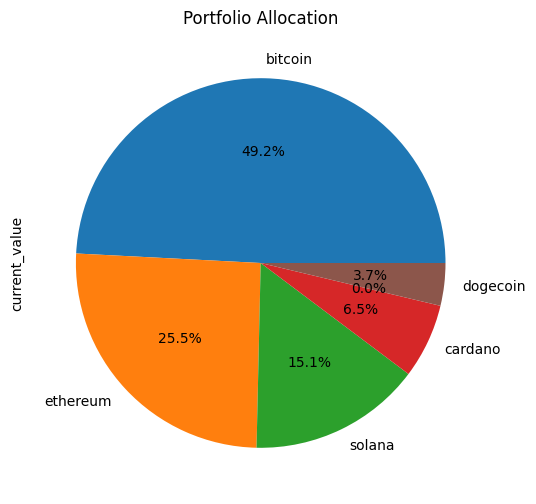

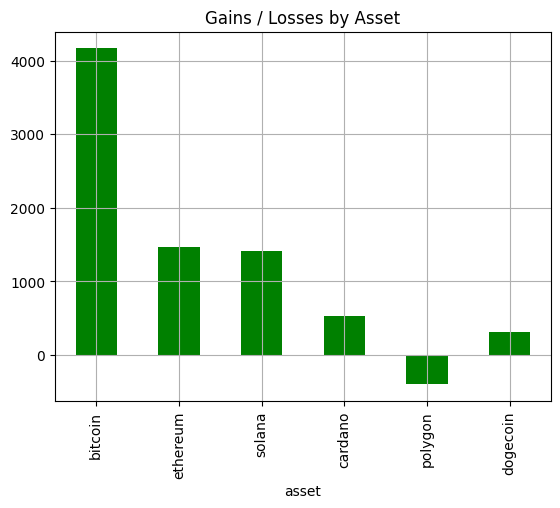

In [18]:
# Pie chart of allocation
portfolio.set_index("asset")["current_value"].plot.pie(autopct="%1.1f%%", figsize=(6, 6), title="Portfolio Allocation")

# Bar chart of gains/losses
portfolio.plot.bar(x="asset", y="gain", color="green" if portfolio["gain"].sum() >= 0 else "red", legend=False)
plt.title("Gains / Losses by Asset")
plt.grid(True)
plt.show()


In [19]:
# Flag assets >40% of portfolio
total_value = portfolio["current_value"].sum()
portfolio["allocation_percent"] = (portfolio["current_value"] / total_value) * 100

overexposed = portfolio[portfolio["allocation_percent"] > 40]
if not overexposed.empty:
    print("⚠️ Overexposed Assets (>40%):")
    print(overexposed[["asset", "allocation_percent"]])
else:
    print("✅ Portfolio is well-diversified.")


⚠️ Overexposed Assets (>40%):
     asset  allocation_percent
0  bitcoin            49.18037


In [21]:
# Load previous outputs
sentiment_df = pd.read_csv("sentiment_news_20250730_1223.csv")  # use the actual file name you saved
portfolio = pd.read_csv("sample_portfolio.csv")

# (If running fresh, you may need to re-add price data using earlier code)


In [22]:
def generate_advice(sentiment_df, portfolio_df):
    # Sentiment Summary
    sentiment_counts = sentiment_df["sentiment"].value_counts().to_dict()
    total = sum(sentiment_counts.values())
    pos = sentiment_counts.get("Positive", 0)
    neg = sentiment_counts.get("Negative", 0)
    neutral = sentiment_counts.get("Neutral", 0)

    if total == 0:
        market_sentiment = "Unknown"
    elif pos > neg and pos > neutral:
        market_sentiment = "Positive"
    elif neg > pos and neg > neutral:
        market_sentiment = "Negative"
    else:
        market_sentiment = "Neutral"

    # Portfolio Check
    portfolio_df["allocation_percent"] = (portfolio_df["current_value"] / portfolio_df["current_value"].sum()) * 100
    overexposed_assets = portfolio_df[portfolio_df["allocation_percent"] > 40]["asset"].tolist()

    # Decision Output
    print(f"📊 Market Sentiment: {market_sentiment}")
    if market_sentiment == "Negative":
        if overexposed_assets:
            print(f"⚠️ Caution: The market is bearish and you are overexposed to {', '.join(overexposed_assets)}.")
        else:
            print("⚠️ Market is negative. Portfolio is balanced, but consider reducing high-risk positions.")
    elif market_sentiment == "Positive":
        print("✅ Market looks positive. You may consider increasing exposure to strong assets.")
    else:
        print("😐 Sentiment is neutral. No major portfolio changes suggested.")


In [24]:
# Re-calculate live prices
def fetch_prices(assets):
    url = "https://api.coingecko.com/api/v3/simple/price"
    ids = ",".join(assets)
    params = {"ids": ids, "vs_currencies": "usd"}
    response = requests.get(url, params=params)
    return response.json()

portfolio["coingecko_id"] = portfolio["asset"].str.lower()
prices = fetch_prices(portfolio["coingecko_id"].tolist())

# Calculate value and gains
def calculate_values(row):
    live_price = prices.get(row["coingecko_id"], {}).get("usd", 0)
    current_value = live_price * row["quantity"]
    invested = row["avg_buy_price"] * row["quantity"]
    gain = current_value - invested
    return pd.Series([live_price, current_value, invested, gain])

portfolio[["live_price", "current_value", "invested", "gain"]] = portfolio.apply(calculate_values, axis=1)
portfolio["gain_percent"] = (portfolio["gain"] / portfolio["invested"]) * 100


In [25]:
generate_advice(sentiment_df, portfolio)


📊 Market Sentiment: Neutral
😐 Sentiment is neutral. No major portfolio changes suggested.
